 ## 1) Import Data , Models & Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_curve, roc_auc_score,f1_score,make_scorer,precision_recall_curve
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

## 2) Data Understanding

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 3) Data Processing

In [5]:
data.columns = data.columns.str.replace(' ', '_')

print(data.columns)


Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')


In [6]:
data = data.drop(columns='phone_number',axis=1)

In [7]:
X = data.drop(columns='churn')
y = data['churn']
X_test, X_train, y_test , y_train = train_test_split(X,y,test_size=0.20,random_state=333)
print(y_train.value_counts())
print(y_test.value_counts())


False    559
True     108
Name: churn, dtype: int64
False    2291
True      375
Name: churn, dtype: int64


In [8]:
# Calculate the proportion of True values in y_train and y_test
train_true_proportion = y_train.value_counts(normalize=True).get(True, 0)
test_true_proportion = y_test.value_counts(normalize=True).get(True, 0)

# Print the proportions and percentage difference
print(f"Proportion of True values in y_train: {train_true_proportion:.2%}")
print(f"Proportion of True values in y_test: {test_true_proportion:.2%}")


Proportion of True values in y_train: 16.19%
Proportion of True values in y_test: 14.07%


In [9]:


# Define the preprocessing function
def preprocess_data(X, scaler=None, fit_scaler=False):
    # Step 1: Create dummy variables, dropping the most frequent state
    X_ohe = pd.get_dummies(X, columns=['state'], prefix='state', drop_first=False)
 

    # Binary encoding
    binary = ['international_plan', 'voice_mail_plan']
    for col in binary:
        if col in X_ohe.columns:
            X_ohe[col] = X_ohe[col].replace({'yes': 1, 'no': 0})

    # Handling area_code
    X_ohe['area_code'] = X_ohe['area_code'].astype('category')
    X_encoded = pd.get_dummies(X_ohe, columns=['area_code'], drop_first=False)
  

    # Separate numeric and categorical features
    X_numeric = X_encoded.select_dtypes(include=['float64', 'int64']).copy()
    X_numeric.drop(columns=binary, axis=1, inplace=True)  # Drop binary columns
    X_categorical = X_encoded.drop(columns=X_numeric.columns, axis=1).copy()

    # Scale numeric features
    if fit_scaler:
        scaler = StandardScaler().fit(X_numeric)
    
    X_numeric_scaled = scaler.transform(X_numeric)
    X_numeric_scaled_df = pd.DataFrame(
        X_numeric_scaled,
        columns=X_numeric.columns,
        index=X_numeric.index
    )

    # Combine scaled numeric features with categorical features
    X_combined = pd.concat([X_numeric_scaled_df, X_categorical], axis=1)

    return X_combined, scaler


# Preprocess X_train
X_train_processed, scaler = preprocess_data(
    X_train, 
    fit_scaler=True
)

# Preprocess X_test using the same scaler fitted on X_train
X_test_processed, _ = preprocess_data(
    X_test, 
    scaler=scaler
)




In [10]:
X_train_processed.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_408,area_code_415,area_code_510
count,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,6.670000e+02,...,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,-1.118546e-16,1.065281e-16,-4.127966e-17,-2.929524e-17,-2.916208e-16,1.118546e-16,2.530043e-17,4.900295e-16,4.261126e-17,2.689836e-16,...,0.013493,0.019490,0.023988,0.016492,0.022489,0.026987,0.025487,0.277361,0.439280,0.283358
std,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,1.000750e+00,...,0.115461,0.138344,0.153127,0.127452,0.148378,0.162166,0.157718,0.448032,0.496672,0.450967
min,-2.549747e+00,-5.939217e-01,-2.905786e+00,-2.815067e+00,-2.906001e+00,-3.279753e+00,-2.971220e+00,-3.280519e+00,-3.396227e+00,-2.690657e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.636735e-01,-5.939217e-01,-6.566537e-01,-6.555936e-01,-6.567955e-01,-7.203678e-01,-6.415744e-01,-7.210948e-01,-6.679535e-01,-6.516178e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.810484e-02,-5.939217e-01,2.419392e-02,1.458777e-02,2.425362e-02,8.231325e-03,3.143451e-02,7.394108e-03,-2.439484e-02,2.806197e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.401220e-01,8.678708e-01,6.619272e-01,6.599476e-01,6.614493e-01,6.398215e-01,6.526735e-01,6.399653e-01,7.051607e-01,6.554587e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,3.576826e+00,3.060560e+00,2.805070e+00,2.496741e+00,2.805513e+00,3.349880e+00,2.930550e+00,3.348730e+00,3.383348e+00,3.949292e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4) Data Modelling

In [11]:

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the classification model on both training and testing data.
    
    Parameters:
    - model: The classification model to be evaluated.
    - X_train: Training features.
    - y_train: Training target.
    - X_test: Testing features.
    - y_test: Testing target.
    
    Returns:
    - None
    """
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute metrics for training data
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_prob)
    
    # Compute metrics for testing data
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_prob)
    
    # Print training metrics
    print("Training Metrics:")
    print("Confusion Matrix:\n", train_conf_matrix)
    print("Accuracy Score:", train_acc)
    print("F1 Score:", train_f1)
    print("Precision:", train_precision)
    print("Recall:", train_recall)
    print("ROC-AUC Score:", train_roc_auc)
    
    # Print testing metrics
    print("\nTesting Metrics:")
    print("Confusion Matrix:\n", test_conf_matrix)
    print("Accuracy Score:", test_acc)
    print("F1 Score:", test_f1)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("ROC-AUC Score:", test_roc_auc)
    
    # Plot ROC-AUC Curve for training and testing data
    plt.figure(figsize=(14, 7))
    
    # ROC Curve for training data
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    plt.plot(fpr_train, tpr_train, marker='.', label='Training ROC Curve (AUC = {:.2f})'.format(train_roc_auc))
    
    # ROC Curve for testing data
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    plt.plot(fpr_test, tpr_test, marker='.', label='Testing ROC Curve (AUC = {:.2f})'.format(test_roc_auc))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


### A. Logistic Regression

Training Metrics:
Confusion Matrix:
 [[537  22]
 [ 51  57]]
Accuracy Score: 0.8905547226386806
F1 Score: 0.6096256684491979
Precision: 0.7215189873417721
Recall: 0.5277777777777778
ROC-AUC Score: 0.9129563373749421

Testing Metrics:
Confusion Matrix:
 [[2121  170]
 [ 251  124]]
Accuracy Score: 0.8420855213803451
F1 Score: 0.37070254110612855
Precision: 0.4217687074829932
Recall: 0.33066666666666666
ROC-AUC Score: 0.6994639895242252


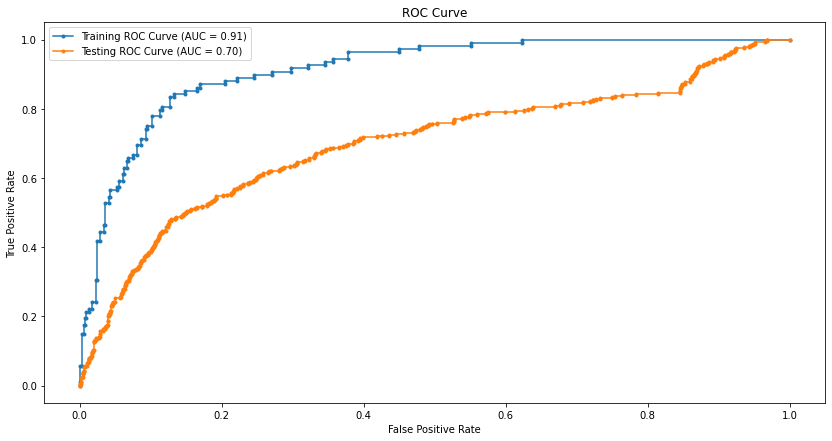

In [12]:
baseline_model = LogisticRegression(fit_intercept=False,C=1e16,penalty='l1', solver='liblinear',random_state=333,max_iter=3000)
baseline_model.fit(X_train_processed,y_train)
evaluate_model(baseline_model,X_train_processed,y_train,X_test_processed,y_test)




A recall of 0.33 means that the model is failing to predict 67% of the churned customers which would be very costly to the stakeholders. Let's see if we can increase recall through resampling of the training set.

In [13]:
smote = SMOTE(random_state=333)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed,y_train)
print(y_train_resampled.value_counts())

True     559
False    559
Name: churn, dtype: int64


Training Metrics:
Confusion Matrix:
 [[528  31]
 [ 69 490]]
Accuracy Score: 0.9105545617173524
F1 Score: 0.9074074074074073
Precision: 0.9404990403071017
Recall: 0.8765652951699463
ROC-AUC Score: 0.9706190136360291

Testing Metrics:
Confusion Matrix:
 [[2087  204]
 [ 247  128]]
Accuracy Score: 0.8308327081770442
F1 Score: 0.3620933521923621
Precision: 0.3855421686746988
Recall: 0.3413333333333333
ROC-AUC Score: 0.6956193801833259


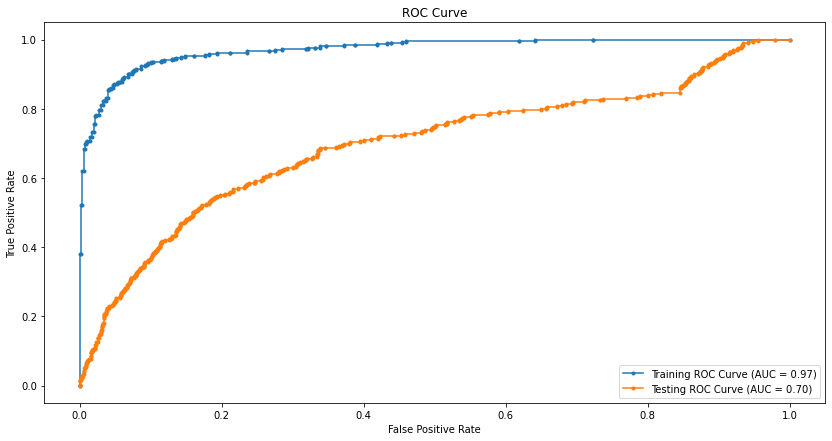

In [14]:

baseline_model.fit(X_train_resampled,y_train_resampled)
evaluate_model(baseline_model,X_train_resampled,y_train_resampled,X_test_processed,y_test)




The log models have similar scores however the model with imbalanced data set is overfitting a little less than the model with resampled data based on the difference scores of the training and test data sets.However recall is still extremely low. To reduce overfitting and increase recall lets reduce the features using SelectKBest.

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    7.1s finished


Best Parameters: {'feature_selection__k': 5, 'logreg__C': 0.01, 'logreg__fit_intercept': False, 'logreg__penalty': 'l2'}
Best Recall Score from GridSearchCV: 0.7972727272727274
Best ROC-AUC Score from GridSearchCV: 0.7449926210153482
Training Metrics:
Confusion Matrix:
 [[336 223]
 [ 21  87]]
Accuracy Score: 0.6341829085457271
F1 Score: 0.41626794258373206
Precision: 0.2806451612903226
Recall: 0.8055555555555556
ROC-AUC Score: 0.7547290134499437

Testing Metrics:
Confusion Matrix:
 [[1365  926]
 [  92  283]]
Accuracy Score: 0.6181545386346586
F1 Score: 0.3573232323232323
Precision: 0.23407775020678245
Recall: 0.7546666666666667
ROC-AUC Score: 0.7353569038265677


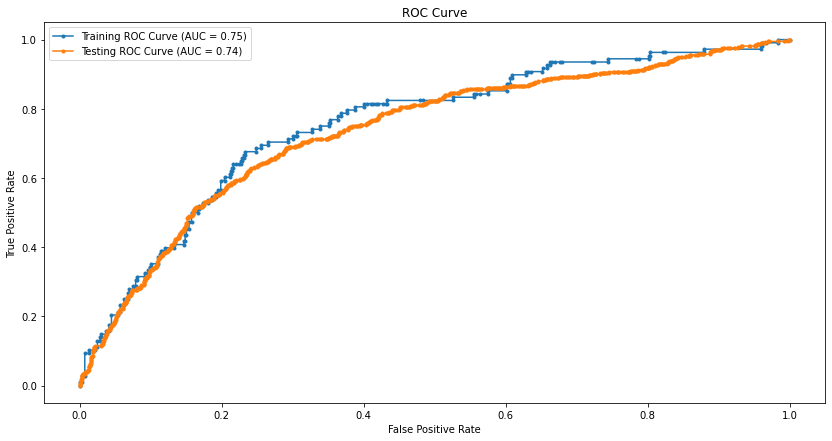

In [15]:


# Define the pipeline with feature selection and logistic regression
log_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('logreg', LogisticRegression(random_state=333, solver='liblinear', max_iter=3000))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5,6,7,8,9,10],  # Number of top features to select
    'logreg__C': [0.001, 0.01, 0.1, 1],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],  # Regularization type
    'logreg__fit_intercept': [True, False]  # Whether to include an intercept
}

# Define recall as a scoring metric
recall_scorer = make_scorer(recall_score)

# Set up the GridSearchCV
log_grid_search = GridSearchCV(
    log_pipeline, 
    param_grid, 
    scoring={'roc_auc': 'roc_auc', 'recall': recall_scorer},  # Include recall as a scoring metric
    refit='recall',  # Refitting based on the best recall score
    cv=10, 
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on training data
tuned_log = log_grid_search.fit(X_train_processed, y_train)

# Get the best parameters and best scores
best_params = tuned_log.best_params_
best_recall_score = tuned_log.cv_results_['mean_test_recall'][log_grid_search.best_index_]
best_roc_auc_score = tuned_log.cv_results_['mean_test_roc_auc'][log_grid_search.best_index_]

# Predict using the best model from GridSearchCV
y_train_pred = tuned_log.predict(X_train_processed)
y_test_pred = tuned_log.predict(X_test_processed)

# Evaluate and compare with the baseline model
print("Best Parameters:", best_params)
print("Best Recall Score from GridSearchCV:", best_recall_score)
print("Best ROC-AUC Score from GridSearchCV:", best_roc_auc_score)
tuned_log_1 = tuned_log.best_estimator_

evaluate_model(tuned_log_1, X_train_processed, y_train, X_test_processed, y_test)


Our hyperparameter tuned log model has a much better recall of 0.75 as well as a higher roc_auc score of 0.74. It is definitely the best model so far. Let's see if we can get a better model with resampled data.

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    4.6s finished


Best Parameters: {'feature_selection__k': 10, 'logreg__C': 0.01, 'logreg__fit_intercept': False, 'logreg__penalty': 'l2'}
Best Recall Score from GridSearchCV: 0.8355519480519481
Best ROC-AUC Score from GridSearchCV: 0.8293512291280148
Training Metrics:
Confusion Matrix:
 [[394 165]
 [ 88 471]]
Accuracy Score: 0.7737030411449016
F1 Score: 0.788284518828452
Precision: 0.7405660377358491
Recall: 0.8425760286225402
ROC-AUC Score: 0.8333754692285291

Testing Metrics:
Confusion Matrix:
 [[1566  725]
 [ 110  265]]
Accuracy Score: 0.6867966991747937
F1 Score: 0.3882783882783883
Precision: 0.2676767676767677
Recall: 0.7066666666666667
ROC-AUC Score: 0.7553289684271789


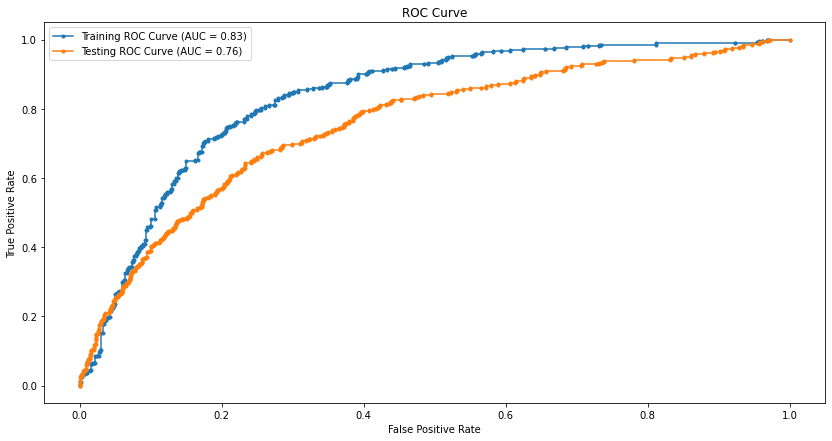

In [16]:

tuned_log_2 = log_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best scores
best_params = tuned_log_2.best_params_
best_recall_score = tuned_log_2.cv_results_['mean_test_recall'][log_grid_search.best_index_]
best_roc_auc_score = tuned_log_2.cv_results_['mean_test_roc_auc'][log_grid_search.best_index_]

# Predict using the best model from GridSearchCV
y_train_pred = tuned_log_2.predict(X_train_resampled)
y_test_pred = tuned_log_2.predict(X_test_processed)

# Evaluate and compare with the baseline model
print("Best Parameters:", best_params)
print("Best Recall Score from GridSearchCV:", best_recall_score)
print("Best ROC-AUC Score from GridSearchCV:", best_roc_auc_score)

evaluate_model(tuned_log_2.best_estimator_, X_train_resampled, y_train_resampled, X_test_processed, y_test)


Our recall has reduced to 70% while roc_auc score has gone up to 76%. However given that our prime objective is to reduce False Negatives, our first tuned model is the most suitable so far.

Training Metrics:
Confusion Matrix:
 [[336 223]
 [ 21  87]]
Accuracy Score: 0.6341829085457271
F1 Score: 0.41626794258373206
Precision: 0.2806451612903226
Recall: 0.8055555555555556
ROC-AUC Score: 0.7547290134499437

Testing Metrics:
Confusion Matrix:
 [[1365  926]
 [  92  283]]
Accuracy Score: 0.6181545386346586
F1 Score: 0.3573232323232323
Precision: 0.23407775020678245
Recall: 0.7546666666666667
ROC-AUC Score: 0.7353569038265677


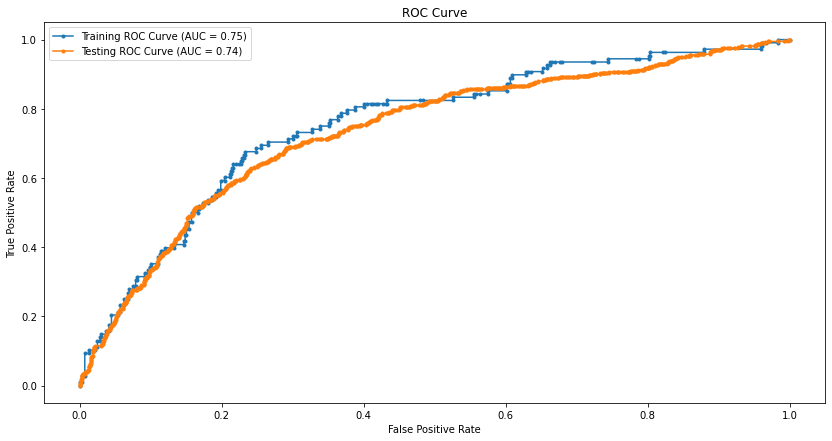

In [17]:

# Step 1: Access the best estimator
best_log_model = tuned_log_1
evaluate_model(best_log_model,X_train_processed,y_train,X_test_processed,y_test)

### B. Decision Tree Classification

Training Metrics:
Confusion Matrix:
 [[559   0]
 [  0 108]]
Accuracy Score: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
ROC-AUC Score: 1.0

Testing Metrics:
Confusion Matrix:
 [[2170  121]
 [  98  277]]
Accuracy Score: 0.917854463615904
F1 Score: 0.7166882276843467
Precision: 0.6959798994974874
Recall: 0.7386666666666667
ROC-AUC Score: 0.8429256510985014


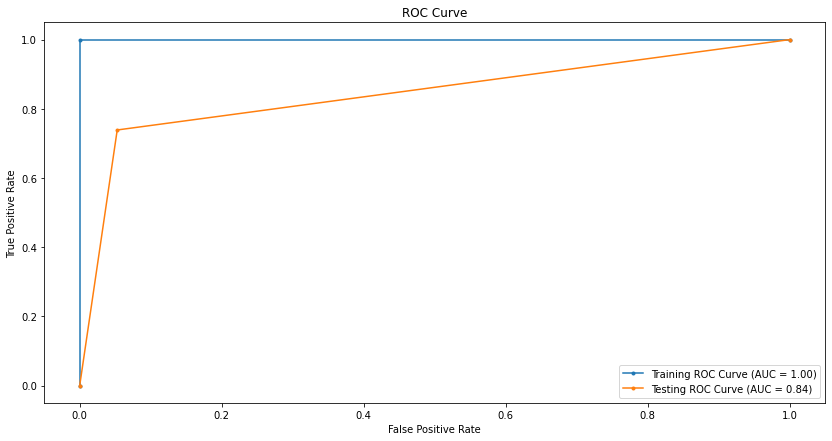

In [18]:
classifier = DecisionTreeClassifier(random_state=333)
classifier.fit(X_train_processed,y_train)
evaluate_model(classifier,X_train_processed,y_train,X_test_processed,y_test)

Our recall has only reduced by 0.01 but roc_auc and precision are much higher. However the model is greatly overfitting. let's see if we can fix that.

Training Metrics:
Confusion Matrix:
 [[559   0]
 [  0 559]]
Accuracy Score: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
ROC-AUC Score: 1.0

Testing Metrics:
Confusion Matrix:
 [[2016  275]
 [  95  280]]
Accuracy Score: 0.8612153038259565
F1 Score: 0.6021505376344085
Precision: 0.5045045045045045
Recall: 0.7466666666666667
ROC-AUC Score: 0.8133158737087152


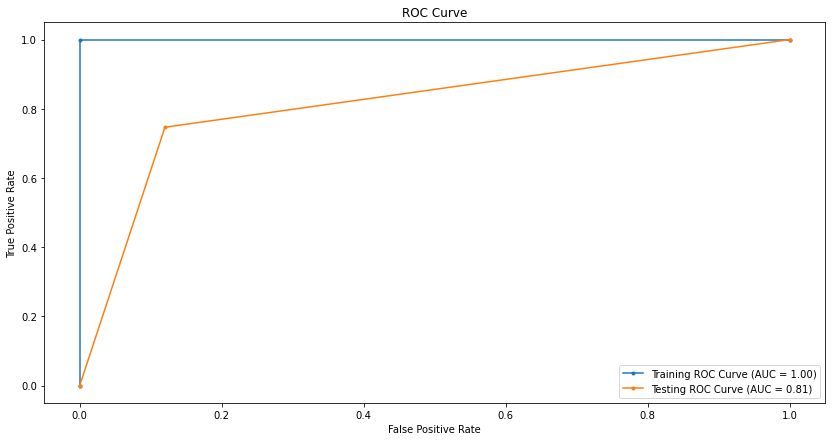

In [19]:
classifier.fit(X_train_resampled,y_train_resampled)
evaluate_model(classifier,X_train_resampled,y_train_resampled,X_test_processed,y_test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.9s finished


Best Parameters (Decision Tree): {'classifier__ccp_alpha': 0.01, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 35, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Best Recall Score from GridSearchCV (Decision Tree): 0.6490909090909092
Best ROC-AUC Score from GridSearchCV (Decision Tree): 0.8475258264462809
Training Metrics:
Confusion Matrix:
 [[551   8]
 [ 26  82]]
Accuracy Score: 0.9490254872563718
F1 Score: 0.8282828282828282
Precision: 0.9111111111111111
Recall: 0.7592592592592593
ROC-AUC Score: 0.9393510236533492

Testing Metrics:
Confusion Matrix:
 [[2193   98]
 [ 163  212]]
Accuracy Score: 0.9021005251312828
F1 Score: 0.618978102189781
Precision: 0.6838709677419355
Recall: 0.5653333333333334
ROC-AUC Score: 0.8526774334351811


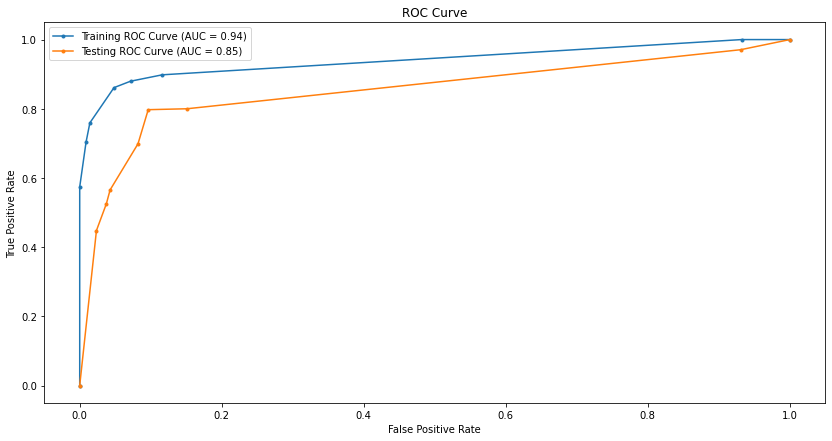

In [32]:


# Define the pipeline
tree_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=333))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [ 10],
    'classifier__min_samples_split': [ 2, 5, 10],
    'classifier__min_samples_leaf': [2, 5, 10],
    'classifier__max_features': [35],
    'classifier__ccp_alpha': [0.01]
}

# Define recall as a scoring metric
recall_scorer = make_scorer(recall_score)

# Set up the GridSearchCV
tree_grid_search = GridSearchCV(
    tree_pipeline, 
    param_grid, 
    scoring={'roc_auc': 'roc_auc', 'recall': recall_scorer},  # Include recall as a scoring metric
    refit='recall',  # Refitting based on the best recall score
    cv=10, 
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on training data
tuned_tree = tree_grid_search.fit(X_train_processed, y_train)

# Get the best parameters and best scores
best_params = tuned_tree.best_params_
best_recall_score = tuned_tree.cv_results_['mean_test_recall'][tree_grid_search.best_index_]
best_roc_auc_score = tuned_tree.cv_results_['mean_test_roc_auc'][tree_grid_search.best_index_]

print("Best Parameters (Decision Tree):", best_params)
print("Best Recall Score from GridSearchCV (Decision Tree):", best_recall_score)
print("Best ROC-AUC Score from GridSearchCV (Decision Tree):", best_roc_auc_score)
tuned_tree_1 = tuned_tree.best_estimator_
# Evaluate the model
evaluate_model(tuned_tree_1, X_train_processed, y_train, X_test_processed, y_test)


We managed to reduce the overfitting however our best decision tree classifier so far is the default one as it has recall of 0.74 and roc_auc of 0.85.

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.9s finished


Best Parameters (Decision Tree): {'classifier__ccp_alpha': 0.01, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 35, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Best Recall Score from GridSearchCV (Decision Tree): 0.8534415584415586
Best ROC-AUC Score from GridSearchCV (Decision Tree): 0.9189137871057514
Training Metrics:
Confusion Matrix:
 [[531  28]
 [ 67 492]]
Accuracy Score: 0.9150268336314848
F1 Score: 0.9119555143651529
Precision: 0.9461538461538461
Recall: 0.8801431127012522
ROC-AUC Score: 0.9639546084401932

Testing Metrics:
Confusion Matrix:
 [[2098  193]
 [  81  294]]
Accuracy Score: 0.8972243060765192
F1 Score: 0.6821345707656612
Precision: 0.6036960985626283
Recall: 0.784
ROC-AUC Score: 0.8785898443183471


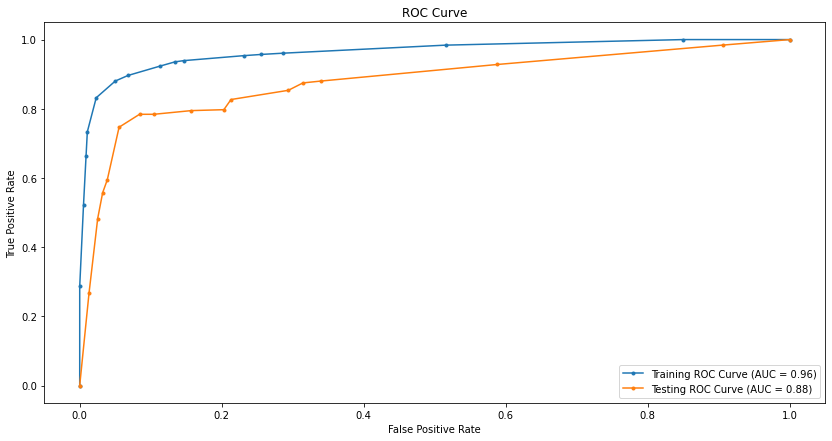

In [33]:


# Fit GridSearchCV on training data
tuned_tree_2 = tree_grid_search.fit(X_train_resampled, y_train_resampled)
# Get the best parameters and best scores
best_params = tuned_tree_2.best_params_
best_recall_score = tuned_tree_2.cv_results_['mean_test_recall'][tree_grid_search.best_index_]
best_roc_auc_score = tuned_tree_2.cv_results_['mean_test_roc_auc'][tree_grid_search.best_index_]

print("Best Parameters (Decision Tree):", best_params)
print("Best Recall Score from GridSearchCV (Decision Tree):", best_recall_score)
print("Best ROC-AUC Score from GridSearchCV (Decision Tree):", best_roc_auc_score)


# Evaluate the model
evaluate_model(tuned_tree_2.best_estimator_, X_train_resampled, y_train_resampled, X_test_processed, y_test)




Our model has improved!, our recall is now 0.78 and roc_auc is 0.88.

Training Metrics:
Confusion Matrix:
 [[531  28]
 [ 13  95]]
Accuracy Score: 0.9385307346326837
F1 Score: 0.8225108225108225
Precision: 0.7723577235772358
Recall: 0.8796296296296297
ROC-AUC Score: 0.9664413966739547

Testing Metrics:
Confusion Matrix:
 [[2098  193]
 [  81  294]]
Accuracy Score: 0.8972243060765192
F1 Score: 0.6821345707656612
Precision: 0.6036960985626283
Recall: 0.784
ROC-AUC Score: 0.8785898443183471


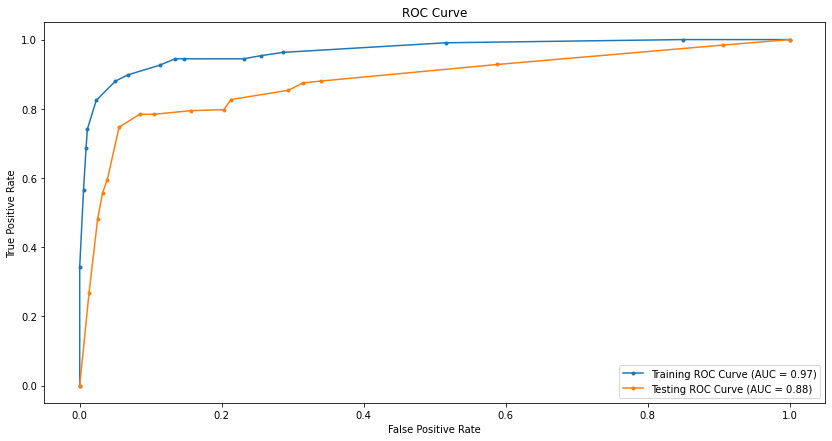

In [34]:
best_tree_model = tuned_tree_2.best_estimator_
evaluate_model(best_tree_model,X_train_processed,y_train,X_test_processed,y_test)

### C. Random Forest Classification

Training Metrics:
Confusion Matrix:
 [[559   0]
 [  0 108]]
Accuracy Score: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
ROC-AUC Score: 1.0

Testing Metrics:
Confusion Matrix:
 [[2270   21]
 [ 265  110]]
Accuracy Score: 0.8927231807951987
F1 Score: 0.43478260869565216
Precision: 0.8396946564885496
Recall: 0.29333333333333333
ROC-AUC Score: 0.8806896551724138


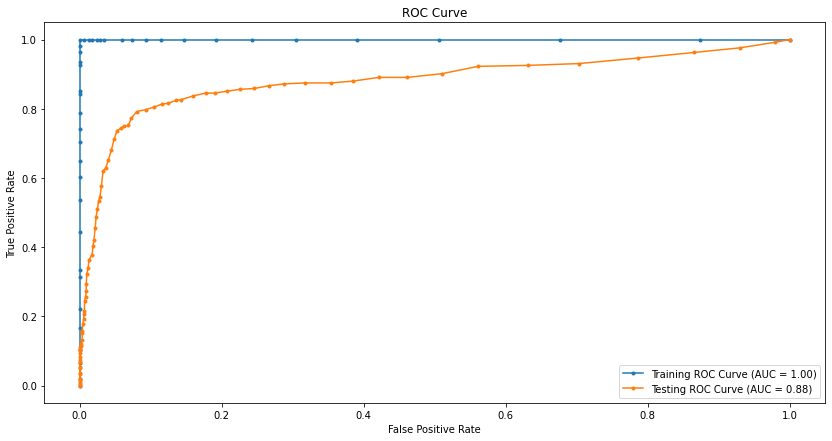

In [23]:
rfc_model_1 = RandomForestClassifier(random_state=333)
rfc_model_1.fit(X_train_processed,y_train)
evaluate_model(rfc_model_1,X_train_processed,y_train,X_test_processed,y_test)

Our recall has gone down to 0.30 making this our worst model, lets see if we can fix that.

Training Metrics:
Confusion Matrix:
 [[559   0]
 [  0 559]]
Accuracy Score: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
ROC-AUC Score: 1.0

Testing Metrics:
Confusion Matrix:
 [[2180  111]
 [ 147  228]]
Accuracy Score: 0.9032258064516129
F1 Score: 0.638655462184874
Precision: 0.672566371681416
Recall: 0.608
ROC-AUC Score: 0.8818251127600756


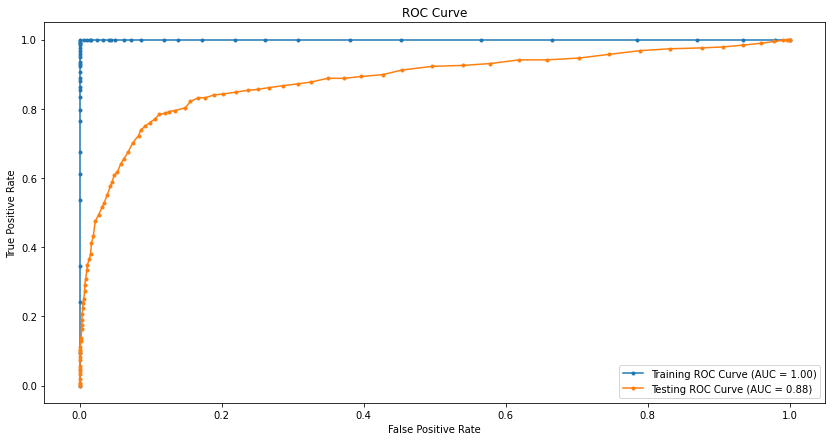

In [24]:
rfc_model_1.fit(X_train_resampled,y_train_resampled)
evaluate_model(rfc_model_1,X_train_resampled,y_train_resampled,X_test_processed,y_test)

Good, our recall has gone up to 0.60  However our best model has a recall of 0.78, so let's see if we can top that by reducing overfitting.

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.6min finished


Best Parameters: {'classifier__ccp_alpha': 0.01, 'classifier__max_depth': 10, 'classifier__max_features': 35, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Recall Score from GridSearchCV: 0.8515909090909091
Best ROC-AUC Score from GridSearchCV: 0.9438613172541744
Training Metrics:
Confusion Matrix:
 [[509  50]
 [ 75 484]]
Accuracy Score: 0.8881932021466905
F1 Score: 0.8856358645928638
Precision: 0.9063670411985019
Recall: 0.8658318425760286
ROC-AUC Score: 0.9641130180714987

Testing Metrics:
Confusion Matrix:
 [[1982  309]
 [  66  309]]
Accuracy Score: 0.8593398349587397
F1 Score: 0.622356495468278
Precision: 0.5
Recall: 0.824
ROC-AUC Score: 0.8797276298559581


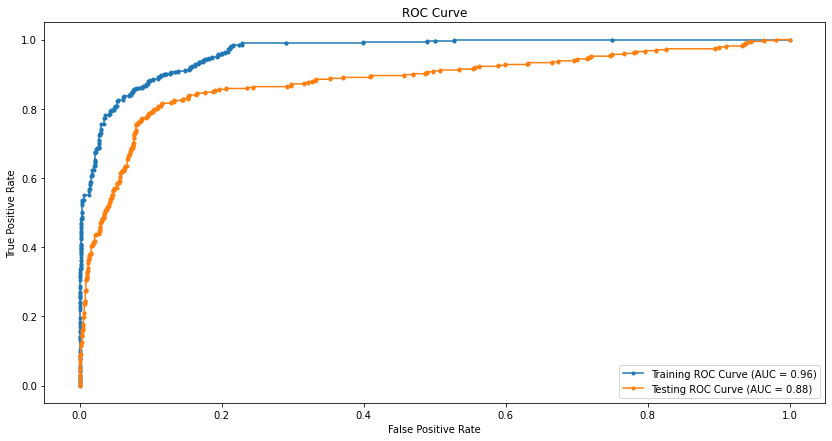

In [44]:

# Define the pipeline
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=333))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100],  # Number of trees in the forest
    'classifier__max_depth': [10],  # Maximum depth of the tree
    'classifier__min_samples_split': [2,5,10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [2,5,10],    # Minimum number of samples required to be at a leaf node
    'classifier__max_features': [30,35,40],  # Number of features to consider when looking for the best split
    'classifier__ccp_alpha': [0.01,0.1,1] # Complexity parameter used for Minimal Cost-Complexity Pruning
}

# Define recall as a scoring metric
recall_scorer = make_scorer(recall_score)

# Set up the GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring={'roc_auc': 'roc_auc', 'recall': recall_scorer},  # Include recall as a scoring metric
    refit='recall',  # Refitting based on the best recall score
    cv=10, 
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on training data
tuned_rfc = grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best scores
best_params = tuned_rfc.best_params_
best_recall_score = tuned_rfc.cv_results_['mean_test_recall'][grid_search.best_index_]
best_roc_auc_score = tuned_rfc.cv_results_['mean_test_roc_auc'][grid_search.best_index_]

print("Best Parameters:", best_params)
print("Best Recall Score from GridSearchCV:", best_recall_score)
print("Best ROC-AUC Score from GridSearchCV:", best_roc_auc_score)

# Predict using the best model from GridSearchCV
y_train_pred = tuned_rfc.predict(X_train_processed)
y_test_pred = tuned_rfc.predict(X_test_processed)
tuned_rfc_1 = tuned_rfc.best_estimator_

# Evaluate the model
evaluate_model(tuned_rfc_1, X_train_resampled, y_train_resampled, X_test_processed, y_test)


The decision tree model and rfc model are extremely close however the rfc model has a 0.82 recall and a slightly better roc_auc which makes it the best performing model based on these metrics.

In [48]:

best_rfc_model = tuned_rfc_1.fit(X_train_resampled,y_train_resampled)
best_overall_model = best_rfc_model

